# Repeated measure ANOVA for short-term

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import json

ValueError: Data is unbalanced.

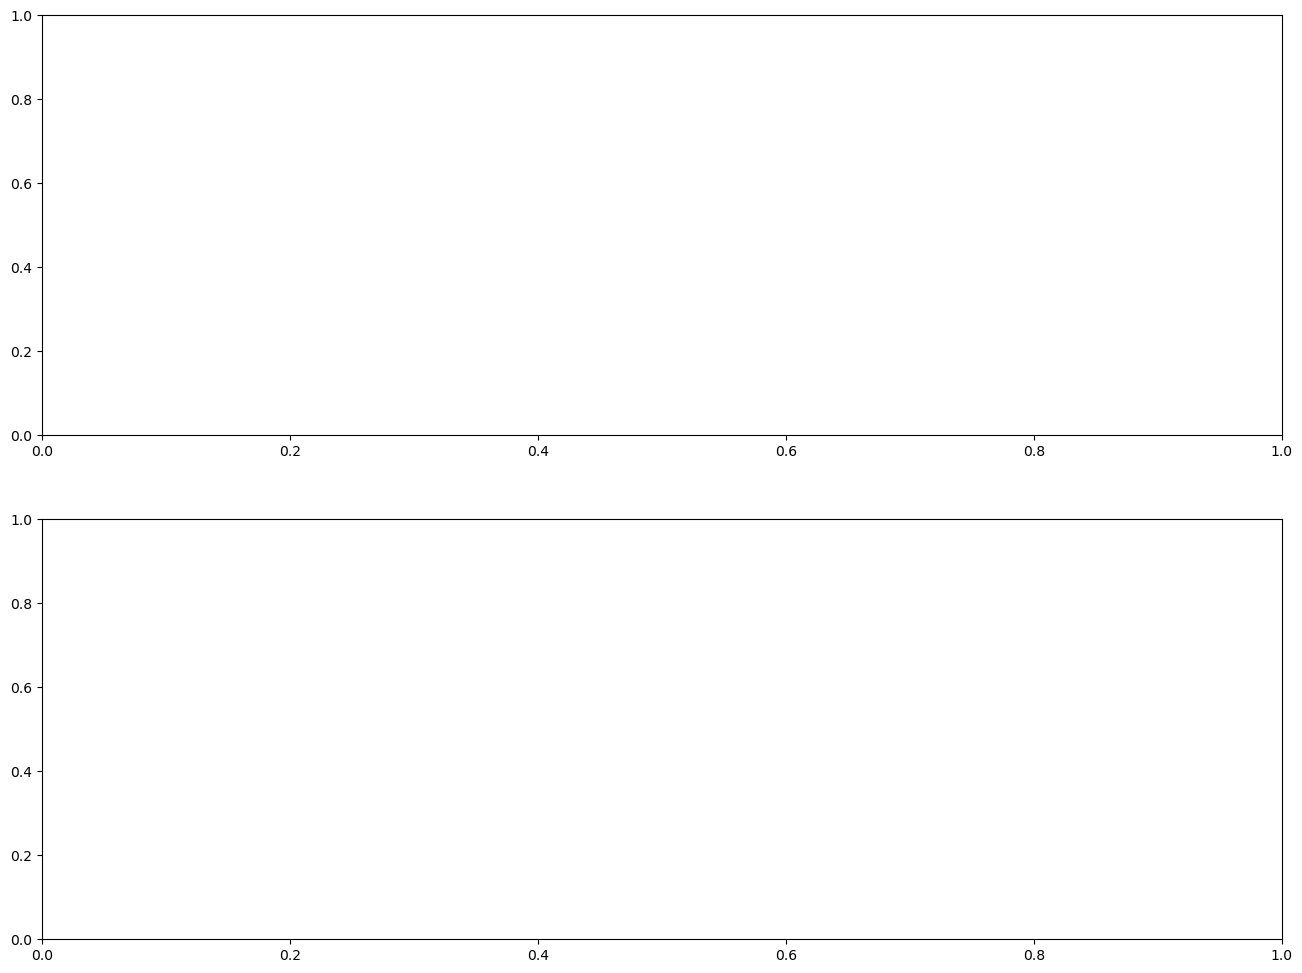

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
import json

# Load the uploaded CSV data
file_path = 'questionnaire/short_term/response_summary_short.csv'
data = pd.read_csv(file_path)

# Extract unique strategies
strategies = data['strategy'].unique()

# Initialize dictionary to store ANOVA results and means of method 0 and method 1
results = {}

# Prepare subplots for combined visualization
fig, axs = plt.subplots(2, 1, figsize=(16, 12))
columns = ['cognitive_load', 'enjoyment']
axes = axs.flatten()

# Iterate over each column of interest
for i, column in enumerate(columns):
    results[column] = {}
    
    # Prepare data for plotting and analysis
    combined_data = []
    labels = []

    for strategy in strategies:
        strategy_data = data[data['strategy'] == strategy]
        
        # Aggregate the data by calculating the mean for each participant, strategy, and method
        aggregated_data = strategy_data.groupby(['participant', 'strategy', 'method'])[column].mean().reset_index()
        
        # Reformat the data for ANOVA
        long_format_data = pd.melt(aggregated_data, id_vars=['participant', 'strategy', 'method'], value_vars=[column],
                                  var_name='variable', value_name='value')
        
        # Perform Repeated Measures ANOVA with aggregation function
        model = AnovaRM(long_format_data, 'value', 'participant', within=['method'], aggregate_func='mean')
        results[column][strategy] = model.fit()
        
        # Prepare data for boxplot
        combined_data.append(aggregated_data[aggregated_data['method'] == 0][column].values)
        combined_data.append(aggregated_data[aggregated_data['method'] == 1][column].values)
        labels.append(f'{strategy} (Method 0)')
        labels.append(f'{strategy} (Method 1)')
    
    # Plotting combined boxplot for each column
    axes[i].boxplot(combined_data, labels=labels, patch_artist=True)
    axes[i].set_title(f'{column.capitalize()} across all Strategies')
    axes[i].set_xlabel('Strategy and Method')
    axes[i].set_ylabel(column.capitalize())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display the combined results dictionary with means and ANOVA results
anova_results = {}
for column, strategy_results in results.items():
    anova_results[column] = {}
    for strategy, result in strategy_results.items():
        anova_results[column][strategy] = {
            'anova_table': result.summary().as_text()
        }

print(json.dumps(anova_results, indent=4))